# Sparsity with PyTorch Tensors: Graph Data Example

![Image of Building ](./building-sparse-graph.jpg)

Photo by <a href="https://unsplash.com/@enginakyurt?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">engin akyurt</a> on <a href="https://unsplash.com/photos/a-very-tall-building-with-a-lot-of-windows-uFzY1WCJWMA?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

## Introduction

The canonical format for representing tensors in PyTorch is the dense tensor, with associated contiguous memory proportional to the size of the tensor. However, in many applications, the data is sparse, that is most of the elements are zero. In this notebook, we will see how to work efficiently with sparse tensors in PyTorch.


### What is sparse dataset?

A dataset is considered sparse when most of its elements are zero, for some features of the dataset. The exact threshold for considering a dataset as sparse is not strictly defined and can depend on the context and the specific application. A common rule of thumb is that a dataset is sparse if over 50% of its elements are zero.

In many real-world applications, datasets can be extremely sparse, with over 90% or even 99% of elements being zero. For example, in a user-item interaction matrix in a recommendation system, each user typically interacts with only a small fraction of all possible items, so the vast majority of the matrix elements are zero.

In PyTorch, datasets are stored in tensors. A tensor is a multi-dimensional array, similar to a NumPy array. PyTorch provides some support for sparse tensors.

### Why does sparsity need special handling?

In a dense tensor, all elements are stored in memory, even if most of them are zero. In a sparse tensor, only the non-zero elements are stored, along with their indices. This can lead to significant memory savings and/or faster compute times, especially for very sparse datasets.

For several tasks which are computing on the tensor, sparse tensors can be more efficient than dense tensors. For example, consider matrix multiplication. If the matrices are sparse, then sparse tensors can be orders of magnitude faster than dense tensors - as we will demonstrate at the end.

### How to create a sparse tensor?

In PyTorch there are several ways to create [sparse tensors](https://pytorch.org/docs/stable/sparse.html) as containers for sparse data. We will see how to create a sparse tensor from a dense tensor, and how to create a sparse tensor from different formats: `COO`, `CSR`, and `CSC`.

First we'll need example data to work with - let's use a graph dataset as an example to understand sparse tensors.


## Example: Graph Data

Graph data is a commonly sparse. A graph is a collection of nodes (or vertices) and edges. The nodes represent entities, and the edges represent relationships between the entities. More often than not, graphs are sparse, i.e. most of the nodes are not connected to each other. It is common to see datasets where less than 1% of the possible edges are present.

There are many ways to represent a Graph. One common is an adjacency matrix, `A`. This is particularly bad for sparse graphs, as most of the elements in the matrix are zero.

The adjacency matrix  is a square matrix `A`, of size `N x N`, where `N` is the number of nodes in the graph. The element `A[i, j]` is 1 if there is an edge between node `i` and node `j`, and 0 otherwise. Since most nodes are not connected to each other, the adjacency matrix is sparse.

Another more memory-efficient way to represent a graph is using a tensor of edges, `E`. Each edge is represented as a 2 long column `(r, s)` in `E`, where `r` and `s` are the indices of the nodes connected by the edge. This representation is more memory-efficient than the adjacency matrix, as it only stores the non-zero elements, it's size is `2 x number_edges`.

In this notebook, we will see how to create a sparse tensor from an adjacency matrix, and how to create a sparse tensor from a list of edges. We will also see how to perform basic operations on sparse tensors, such as matrix multiplication and element-wise operations.


Let's consider an example from the ModelNet10 dataset. 

### ModelNet10 Dataset

`ModelNet10` is a subset of the ModelNet dataset, which is a large-scale 3D CAD model dataset. ModelNet10 specifically consists of 10 categories, with a total of 4899 3D CAD models. The categories include: bed, chair, monitor, desk, dresser, sofa, table, toilet, night stand, and bathtub.

Each 3D model in the dataset is represented as a graph, where each node represents a point in the 3D object, and each edge represents a relationship between the points. The adjacency matrix of the graph is sparse, as most of the points are not connected to each other.

This dataset is commonly used for benchmarking in tasks such as 3D object recognition, shape classification, and other machine learning tasks involving 3D data.

Let's look at a one: a Monitor from the training dataset. We'll need to install some libraries to visualize the 3D object.


In [84]:
!pip -q install numpy matplotlib networkx

The data is in `off` format - that is nodes and edges making faces. The particular file can be found [here](https://zenodo.org/records/5940164). The corners of the monitor are the nodes and the edges are the connections between the corners. Here's a plot using `matplotlib` and another with `trimesh`.

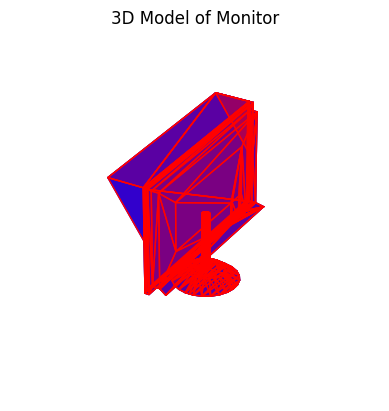

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, _ = tuple(map(int, file.readline().strip().split(' ')))
    verts = [[float(s) for s in file.readline().strip().split(' ')] for _ in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')[1:]] for _ in range(n_faces)]
    return verts, faces

with open('./data/monitor_0001.off', 'r') as f:
    verts, faces = read_off(f)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a Poly3DCollection object
polys = [np.array(verts)[face] for face in faces]
collection = Poly3DCollection(polys, linewidths=1, alpha=1)
collection.set_facecolor((0,0,1,0.5))  # Set the color of the object to blue
collection.set_edgecolor((0,0,1,0.5))  # Set the edge color to a darker blue
ax.add_collection3d(collection)

# Add lighting
ax.add_collection3d(Poly3DCollection(polys, facecolors='r', linewidths=1, edgecolors='r', alpha=.20))

# Remove the axes for a cleaner look
ax.axis('off')

# Auto scale to the mesh size
scale = np.array(verts).flatten()
ax.auto_scale_xyz(scale, scale, scale)

# Add a title to the plot
ax.set_title('3D Model of Monitor')

plt.show()


In [87]:
pip -q install trimesh

Note: you may need to restart the kernel to use updated packages.


In [209]:
import trimesh

# Load the mesh from the OFF file
mesh = trimesh.load_mesh('./data/monitor_0001.off')

# Plot the mesh
mesh.show()

To see this data as a graph, we will feed in vertices and faces into the networkx package.

In [54]:
import matplotlib.pyplot as plt
import networkx as nx


def off_to_graph(verts, faces):
    # Create a new graph
    G = nx.Graph()
    # Add nodes to the graph
    for i in range(len(verts)):
        G.add_node(i)
    # Add edges to the graph
    for face in faces:
        for i in range(len(face)):
            # Add an edge between each pair of vertices in the face
            G.add_edge(face[i], face[(i+1)%len(face)])
    return G

with open('./data/monitor_0001.off', 'r') as f:
    verts, faces = read_off(f)

G = off_to_graph(verts, faces)

In [55]:
print(G)

Graph with 798 nodes and 1476 edges


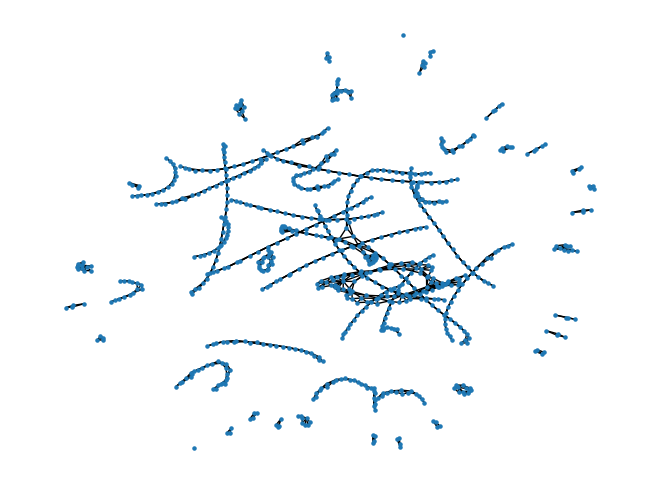

In [103]:
# Draw the graph
nx.draw(G, edge_color="black", width=1, node_size=5, with_labels=False)
plt.show()

So, that's the graph. It's difficult to make out the shape of the monitor from the plot above, as we're not representing the features of the nodes (3d co-ordinates).


What we can do is list out the edges and vertices of the graph. First in edge list format with the corresponding nodes.

In [57]:
G.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 10), (9, 10), (9, 11), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13), (12, 14), (13, 14), (13, 15), (14, 15), (14, 16), (15, 16), (15, 17), (16, 17), (16, 18), (17, 18), (17, 19), (18, 19), (18, 20), (19, 20), (19, 21), (20, 21), (20, 22), (21, 22), (21, 23), (22, 23), (22, 24), (23, 24), (23, 25), (24, 25), (24, 26), (24, 27), (25, 26), (26, 27), (28, 29), (28, 30), (28, 31), (28, 32), (29, 30), (29, 85), (29, 87), (30, 31), (30, 87), (31, 32), (33, 34), (33, 35), (33, 88), (34, 35), (34, 88), (34, 36), (35, 36), (35, 37), (36, 37), (36, 38), (37, 38), (37, 39), (38, 39), (38, 40), (39, 40), (39, 41), (40, 41), (40, 42), (41, 42), (41, 43), (42, 43), (42, 44), (43, 44), (43, 45), (44, 45), (44, 46), (45, 46), (45, 47), (46, 47), (48, 49), (48, 50), (49, 50), (49, 51), (50, 52), (50, 51), (51, 52), (51, 53), (52, 54), (52, 53), (53, 54

In [104]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

And then as a an adjacency matrix.

In [78]:
A = nx.to_numpy_array(G)

In [80]:
A.shape

(798, 798)

In [81]:
print(A)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


Let's verify that the number of edges match the adjacency matrix.

In [108]:
A.sum() / 2

1476.0

In [106]:
A.sum()/2 == len(G.edges()) # The number of edges.

True

## Sparse Adjacency 

The adjacency is sparse. We can quantify this sparsity - the ratio of the number of non-zero elements to the total number of elements in the tensor.

In [109]:
# the ratio of the number of non-zero elements to the total number of elements in the tensor A.
np.count_nonzero(A) / (A.shape[0] * A.shape[1])

0.004635649273559839

Storing data in this format is inefficient. We can convert it to a sparse tensor. We'll create functions for popular formats, as well as look at the native PyTorch implementations.

## Sparse Formats

Some well known sparse tensor representation formats are:

* Coordinate (`COO`)
* Compressed Sparse Row (`CSR`)
* Compressed Sparse Column (`CSC`)
* Block Compressed Sparse Row (`BSR`)
* Dictionary of Keys (`DOK`)
* List of Lists (`LIL`)

We'll look at `COO`, `CSR`, and `CSC` formats.

The monitor graph is too large and sparse for illustration purposes. We'll create a smaller graph to demonstrate the conversion back and forth to sparse tensors.


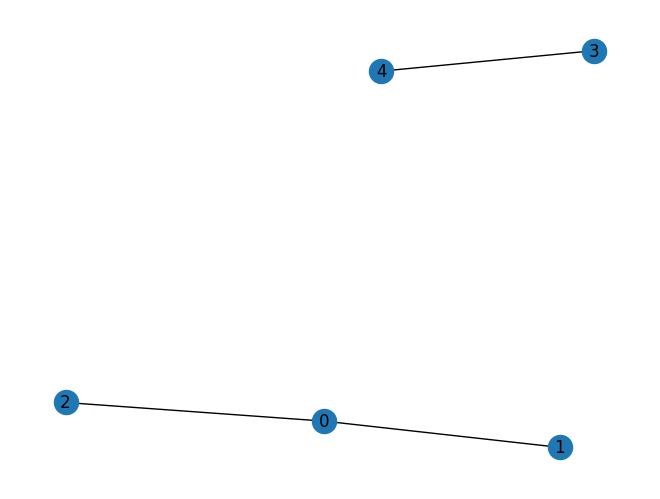

In [159]:
# Create a new graph
G = nx.Graph()

# Add some edges to the graph
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(3, 4)

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [160]:
pip -q install torch

Note: you may need to restart the kernel to use updated packages.


In [165]:
import torch

A = nx.to_numpy_array(G)
print(torch.from_numpy(A))
A_torch = torch.from_numpy(A).bool()
A_torch

tensor([[0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)


tensor([[False,  True,  True, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False,  True, False]])

In [162]:
A.sum()/2

3.0

Let's express as a pandas dataframe with source and target nodes for edges.

In [164]:
pip -q install pandas

Note: you may need to restart the kernel to use updated packages.


In [175]:
import numpy as np
import pandas as pd

# Get the number of nodes
num_nodes = A_torch.shape[0]

# Create a list of all pairs of nodes
source_node, destination_node = np.meshgrid(np.arange(num_nodes), np.arange(num_nodes))

# Flatten the arrays
source_node = source_node.flatten()
destination_node = destination_node.flatten()

# Get the edge values
has_edge = A_torch[source_node, destination_node] > 0

# Create the DataFrame
df = pd.DataFrame({
    'source_node': source_node,
    'destination_node': destination_node,
    'has_edge': has_edge
})

df

,source_node,destination_node,has_edge
0,0,0,False
1,1,0,True
2,2,0,True
3,3,0,False
4,4,0,False
5,0,1,True
6,1,1,False
7,2,1,False
8,3,1,False
9,4,1,False


### COO Format

The `COO` format is simple and flexible for sparse matrices. It consists of three arrays: `row`, `col`, and `data`. The `row` array contains the row indices of the non-zero elements, the `col` array contains the column indices of the non-zero elements, and the `data` array contains the values of the non-zero elements.

Luckily, PyTorch has built in methods for converting between dense and sparse tensors. We can convert the adjacency matrix to a COO sparse tensor using the `.to_sparse()` method.

In [189]:
A_coo_pytorch = A_torch.to_sparse()
A_coo_pytorch

tensor(indices=tensor([[0, 0, 1, 2, 3, 4],
                       [1, 2, 0, 0, 4, 3]]),
       values=tensor([True, True, True, True, True, True]),
       size=(5, 5), nnz=6, layout=torch.sparse_coo)

And convert back

In [190]:
A_coo_pytorch.to_dense()

tensor([[False,  True,  True, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False,  True, False]])

Let's look at the sparse tensor as a dataframe of source to destination nodes, but this time only for those pairs where there is an edge.

In [192]:
# Get the source and destination nodes and the edge values
source_node = A_coo_pytorch.indices()[0].numpy()
destination_node = A_coo_pytorch.indices()[1].numpy()
has_edge = A_coo_pytorch.values().numpy()

# Create the DataFrame
df = pd.DataFrame({
    'source_node': source_node,
    'destination_node': destination_node,
    'has_edge': has_edge
})
df

,source_node,destination_node,has_edge
0,0,1,True
1,0,2,True
2,1,0,True
3,2,0,True
4,3,4,True
5,4,3,True


Writing our own homebrew function to convert to COO format, is straightforward.

In [195]:
def to_sparse(tensor):
    # Get the indices of the non-zero elements
    indices = torch.nonzero(tensor).t()
    # Get the values of the non-zero elements
    values = tensor[indices[0], indices[1]]  # assuming 2D tensor
    # Get the size of the original tensor
    size = tensor.size()
    # Create a sparse tensor
    sparse_tensor = torch.sparse_coo_tensor(indices, values, size)
    return sparse_tensor

In [196]:
to_sparse(A_torch)

tensor(indices=tensor([[0, 0, 1, 2, 3, 4],
                       [1, 2, 0, 0, 4, 3]]),
       values=tensor([True, True, True, True, True, True]),
       size=(5, 5), nnz=6, layout=torch.sparse_coo)

In [201]:
def to_dense(sparse_tensor):
    # Get the size of the original tensor
    size = sparse_tensor.size()
    # Get the indices and values from the sparse tensor
    indices = sparse_tensor.coalesce().indices()
    values = sparse_tensor.coalesce().values()
    # Create a dense tensor of the same size and data type as values, initialized with zeros
    dense_tensor = torch.zeros(size, dtype=values.dtype)
    # Convert indices to a tuple of tensors
    indices_tuple = tuple(indices[i] for i in range(indices.shape[0]))
    # Use index_put_ to put the values in the dense tensor at the right indices
    dense_tensor.index_put_(indices_tuple, values, accumulate=False)
    return dense_tensor

In [202]:
to_dense(A_coo_pytorch)

tensor([[False,  True,  True, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False,  True, False]])

### CSR Format



`CSR` is an even more efficient compact format for sparse data. Details can be found [here](https://en.wikipedia.org/wiki/Sparse_matrix#:~:text=The%20compressed%20sparse%20row%20(CSR,row%20indices%2C%20hence%20the%20name.)).

Values and column indices are stored in the same way as `COO` format. The row indices are stored in a separate array, which can seem strange at first glance.

Broadly it relies on slicing the values into per row chunks. The row chunk lengths are calculated as the difference between the row indices of the non-zero elements. The row chunk lengths are stored in a separate array, `row_ptr`.

So, if your original matrix has m rows, n columns, and nnz non-zero values, then:

* The shape of values is [nnz].

* The shape of column_indices is [nnz].

* The shape of row_pointers is [m+1].

In index notation, the row pointer array is defined as:

```
row_ptr[i] = row_ptr[i-1] + number of non-zero elements in row i-1
```



So, the row pointer array stores the cumulative sum of the number of non-zero elements in each row.

the row and column number can be determined by the index of the non-zero element in the values array. That is the `i-th` non-zero element (in the values array) is at row `row_ptr[i]` and column `col[i]`. That is:


values[i] = A[row_ptr[i], col[i]]



In [203]:
A_torch.to_sparse_csr()

/var/folders/p9/vwq0gfs15vb07tg6xw1r14180000gn/T/ipykernel_58234/2480968404.py:1: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  A_torch.to_sparse_csr()


tensor(crow_indices=tensor([0, 2, 3, 4, 5, 6]),
       col_indices=tensor([1, 2, 0, 0, 4, 3]),
       values=tensor([True, True, True, True, True, True]), size=(5, 5), nnz=6,
       layout=torch.sparse_csr)

Which can be recovered by chaining with the `.to_dense()` method.

In [204]:
A_torch.to_sparse_csr().to_dense()

tensor([[False,  True,  True, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False,  True, False]])

And here we write our homebrew version of to_csr() and from_csr() functions:

In [261]:
def to_csr(tensor):
    # Get the indices of the non-zero elements
    indices = torch.nonzero(tensor, as_tuple=True)
    # Get the values of the non-zero elements
    values = tensor[indices]
    # Get the column indices of the non-zero elements
    column_indices = indices[1]
    # Get the row pointers
    row_pointers = torch.zeros(tensor.size(0) + 1, dtype=torch.long)
    row_pointers[1:] = torch.bincount(indices[0])
    row_pointers = torch.cumsum(row_pointers, dim=0)

    return values, column_indices, row_pointers

In [206]:
to_csr(A_torch)

(tensor([True, True, True, True, True, True]),
 tensor([1, 2, 0, 0, 4, 3]),
 tensor([0, 2, 3, 4, 5, 6]))

In [262]:
def from_csr(values, column_indices, row_pointers):
    # Get the number of rows and columns
    num_rows = row_pointers.size(0) - 1
    num_cols = torch.max(column_indices).item() + 1
    # Create a dense tensor of the right size, initialized with zeros
    tensor = torch.zeros((num_rows, num_cols), dtype=values.dtype)
    # Loop over the rows
    for i in range(num_rows):
        # Get the start and end indices for this row in the values and column_indices arrays
        start = row_pointers[i].item()
        end = row_pointers[i + 1].item()
        # Set the values in the dense tensor for this row
        tensor[i, column_indices[start:end]] = values[start:end]

    return tensor

In [263]:
from_csr(*to_csr(A_torch))

tensor([[False,  True,  True, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False,  True, False]])

### CSC Format

The CSC format is similar to the CSR format, but with the rows and columns swapped. The values and row indices are stored in the same way as the CSR format. The column indices are stored in a separate array, `col_ptr`.

This format is efficient for certain slicing operations, such as extracting a column from a matrix.

## Memory Usage & Speed Up with Sparse Tensors on the Monitor Graph

Let's see how much faster it is to perform matrix multiplication on the sparse tensor compared to the dense tensor. For this we'll use the ModelNet10 monitor graph seen earlier.

In [264]:
with open('./data/monitor_0001.off', 'r') as f:
    verts, faces = read_off(f)

G = off_to_graph(verts, faces)
A = nx.adjacency_matrix(G)
A

<798x798 sparse array of type '<class 'numpy.int64'>'
	with 2952 stored elements in Compressed Sparse Row format>

`A` is already a sparse matrix, but in numpy. We'll convert it to a PyTorch dense tensor first.

In [265]:
A_dense = torch.from_numpy(A.toarray())
A_dense.shape

torch.Size([798, 798])

In [239]:
def tensor_memory_usage_str(tensor=None):
    if tensor is None:
        return "No tensor provided"
    bytes = tensor.element_size() * tensor.nelement()
    kilobytes = bytes / 1024
    return f"Memory usage: {bytes} bytes ({kilobytes} KB)"

In [240]:
tensor_memory_usage_str(A_dense)

'Memory usage: 5094432 bytes (4975.03125 KB)'

In [241]:
tensor_memory_usage_str(A_dense.to_sparse())

'Memory usage: 5094432 bytes (4975.03125 KB)'

Somewhat unexpectedly, the sparse and dense tensors have the same memory usage.

In [246]:
A_sparse = A_dense.to_sparse_csr()
A_sparse

tensor(crow_indices=tensor([   0,    5,    8,   10,   13,   17,   21,   25,
                              29,   33,   37,   41,   45,   49,   53,   57,
                              61,   65,   69,   73,   77,   81,   85,   89,
                              93,   98,  101,  104,  106,  110,  114,  118,
                             121,  123,  126,  130,  134,  138,  142,  146,
                             150,  154,  158,  162,  166,  170,  174,  177,
                             179,  181,  184,  188,  192,  196,  200,  204,
                             208,  212,  216,  220,  224,  228,  232,  235,
                             239,  243,  246,  250,  254,  258,  262,  266,
                             270,  274,  278,  282,  286,  289,  291,  295,
                             298,  302,  306,  310,  314,  318,  322,  326,
                             330,  332,  334,  336,  338,  345,  350,  354,
                             360,  370,  374,  379,  384,  388,  393,  399,
            

In [247]:
tensor_memory_usage_str(A_sparse)

'Memory usage: 5094432 bytes (4975.03125 KB)'

OK, so there was no improvement in memory usage for this particular case. Let's time the matrix multiplication operations.

In [257]:
import timeit


def multiply_tensors():
    return A_dense @ A_dense

num_runs = 10
time_taken_dense = timeit.timeit( multiply_tensors, number=num_runs)

print(f"Time taken by my_function over {num_runs} runs: {time_taken_dense} seconds")

Time taken by my_function over 10 runs: 2.5863237919984385 seconds


In [260]:
A_coo = A

def multiply_tensors():
    return A_coo@A_coo

num_runs = 10
time_taken_sparse = timeit.timeit( multiply_tensors, number=num_runs)

print(f"Time taken by my_function over {num_runs} runs: {time_taken_sparse} seconds")

Time taken by my_function over 10 runs: 2.5863237919984385 seconds


That's almost 1000x difference when using coo encoding. 

With CSR encoding of sparse tensors, it might be even better - however I'm on Apple Silicon, and the csr sparse tensor support is not yet available for this architecture.

## Conclusion


We just saw how to work with sparse tensors in PyTorch. We created a sparse tensor from an adjacency matrix and a list of edges, and converted it to different sparse formats. We also saw the performance benefits of using sparse tensors for matrix multiplication. There's a lot more to sparsity, and PyTorch is actively developing its sparse tensor support. Things will break, but expect ramp up in performance gains.